In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../plotting.mplstyle')

In [2]:
sys.path.insert(0,'../../../scripts')

In [3]:
import reactor_deployment as dep
import scenario_definitions as sd

In [4]:
# read in the LWR deployment data so we can establish a baseline.
lwr_df = pd.read_csv('lwr_info.csv')

# Remove the 'Unnamed: 0' column
lwr_df = lwr_df.drop('Unnamed: 0', axis=1)

In [5]:
lwr_df['retirement_year'] = lwr_df['Actual retirement (year)'].fillna(
    lwr_df['Startup date (year) b'] + 80)

In [6]:
lwr_df

,Reactor name,State,Reactor type,Reactor vendora,Core size (number of assemblies),Startup date (year) b,License expiration (year),Actual retirement (year),power_cap(MWe),retirement_year
0,Arkansas_Nuclear_One_1,AR,PWR,B&W,177,1974,2034,NaN,836.0,2054.0
1,Arkansas_Nuclear_One_2,AR,PWR,CE,177,1978,2038,NaN,988.0,2058.0
2,Beaver_Valley_1,PA,PWR,WE,157,1976,2036,NaN,908.0,2056.0
3,Beaver_Valley_2,PA,PWR,WE,157,1987,2047,NaN,905.0,2067.0
4,Big_Rock_Point,MI,BWR,GE,84,1964,NaN,1997.0,67.0,1997.0
...,...,...,...,...,...,...,...,...,...,...
118,Watts_Bar_2,TN,PWR,WE,193,2016,2055,NaN,1164.0,2096.0
119,Wolf_Creek_1,KS,PWR,WE,193,1985,2045,NaN,1200.0,2065.0
120,Yankee_Rowe,MA,PWR,WE,76,1960,NaN,1991.0,167.0,1991.0
121,Zion_1,IL,PWR,WE,193,1973,NaN,1997.0,1040.0,1997.0


In [7]:
capacity_change = {year: 0 for year in range(sd.sim_start_yr, sd.sim_end_yr)}

# calculate the decommissioned capacity for each retirement year
for year, power in zip(lwr_df['retirement_year'], lwr_df['power_cap(MWe)']):
    capacity_change[int(year)] -= power * sd.lwr_capacity_factor

# calculate the commissioned LWR capacity for each startup year
for year, power in zip(lwr_df['Startup date (year) b'], lwr_df['power_cap(MWe)']):
    capacity_change[int(year)] += power * sd.lwr_capacity_factor

/tmp/ipykernel_31908/3600157219.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])


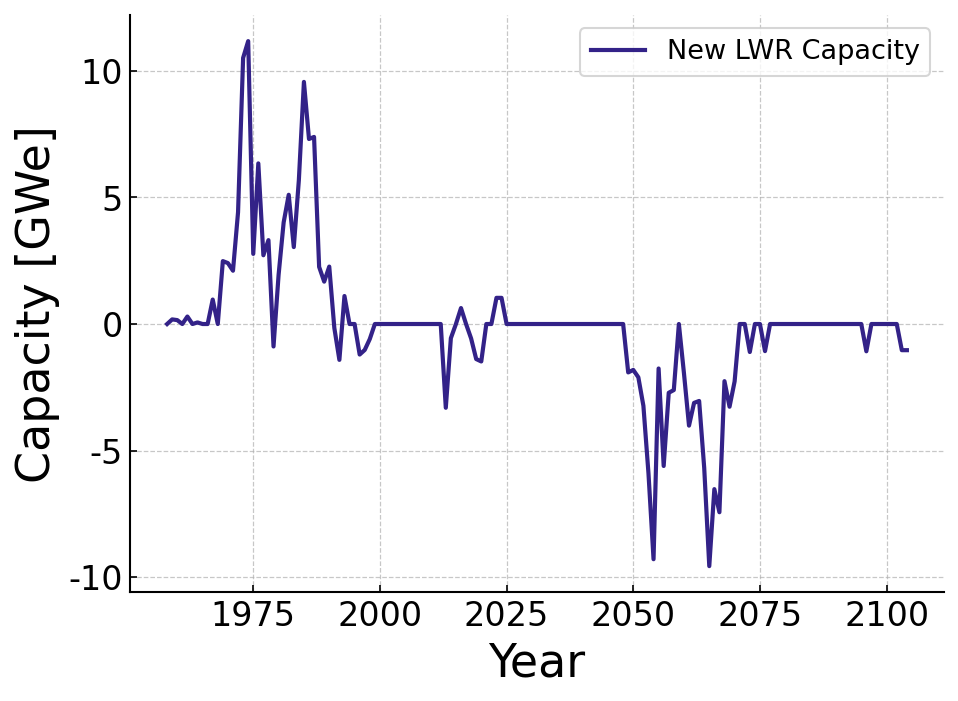

In [8]:
# Convert to a pandas DataFrame and plot.
capacity_change_df = pd.DataFrame(capacity_change.values(), index=capacity_change.keys(), columns=['new_LWR_Capacity'])
capacity_change_df.plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('New LWR Capacity')

In [9]:
# create a total lwr capacity column
capacity_change_df['Total LWR Capacity'] = capacity_change_df['new_LWR_Capacity'].cumsum()

/tmp/ipykernel_31908/722816693.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])


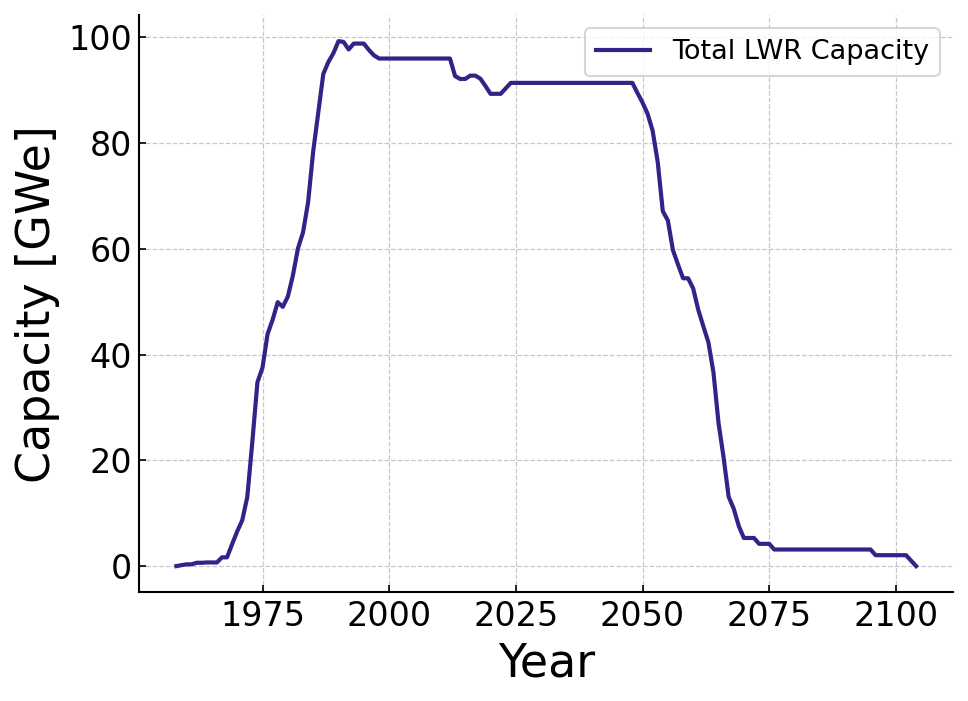

In [10]:
capacity_change_df[["Total LWR Capacity"]].plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('Total LWR Capacity')

In [11]:
# create a time step column that subtracts the start year from the current year and multiplies by 12
capacity_change_df['time_step'] = (capacity_change_df.index - sd.sim_start_yr) * 12

In [12]:
capacity_change_df

,new_LWR_Capacity,Total LWR Capacity,time_step
1958,0.000,0.000000e+00,0
1959,182.225,1.822250e+02,12
1960,154.475,3.367000e+02,24
1961,0.000,3.367000e+02,36
1962,296.000,6.327000e+02,48
...,...,...,...
2100,0.000,2.066450e+03,1704
2101,0.000,2.066450e+03,1716
2102,0.000,2.066450e+03,1728
2103,-1033.225,1.033225e+03,1740


In [13]:
# create a function that will generate the deployinst.xml file for each reactor column by reading in the number of reactors at each time step and converting it into a deployinst.xml file
def generate_deployinst_xml(df, reactor_name, transition_year=sd.transition_year):
  start_row = df.loc[df['Year']==transition_year].index[0]
  deployinst_xml = """<DeployInst>
               <prototypes>"""

  for time_step in df['time_step'].loc[start_row:]:
    deployinst_xml += f"""
                <val>{reactor_name}</val>"""

  deployinst_xml += """
               </prototypes>
               <build_times>"""

  for time_step in df['time_step'].loc[start_row:]:
    deployinst_xml += f"""
               <val>{int(time_step)}</val>"""

  deployinst_xml += """
               </build_times>
               <n_build>"""

  for num_reactors in df[reactor_name].loc[start_row:]:
    deployinst_xml += f"""
               <val>{int(num_reactors)}</val>"""

  deployinst_xml += """
               </n_build>
             </DeployInst>"""

  return deployinst_xml.strip()

# No Growth

In [14]:
base_capacity = capacity_change_df.loc[sd.transition_year, 'Total LWR Capacity'] # in MWe

print(f"Total LWR capacity in {sd.transition_year}: {base_capacity} MWe")

Total LWR capacity in 2029: 91345.60000000002 MWe


In [15]:
no_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=no_growth_cap_df, base_col='Total LWR Capacity', rate=1, start_year=sd.transition_year, end_year=sd.sim_end_yr)

,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1,New Capacity Inc 1
1958,0.000,0.000000e+00,0,0.000,0.000
1959,182.225,1.822250e+02,12,182.225,0.000
1960,154.475,3.367000e+02,24,336.700,0.000
1961,0.000,3.367000e+02,36,336.700,0.000
1962,296.000,6.327000e+02,48,632.700,0.000
...,...,...,...,...,...
2100,0.000,2.066450e+03,1704,91345.600,89279.150
2101,0.000,2.066450e+03,1716,91345.600,89279.150
2102,0.000,2.066450e+03,1728,91345.600,89279.150
2103,-1033.225,1.033225e+03,1740,91345.600,90312.375


In [16]:
greedy_no_growth_cap_df = no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

In [17]:
dep.rand_greedy_deployment(greedy_no_growth_cap_df, "New Capacity Inc 1", sd.ad_reactors, sd.transition_year, set_seed=True)

,Year,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1,New Capacity Inc 1,num_AP1000,num_Xe100,num_MMR,AP1000Decom,...,Xe100_cap,new_MMR_cap,MMR_cap,remaining_cap,greedy_num_AP1000,rand_num_AP1000,greedy_num_Xe100,rand_num_Xe100,greedy_num_MMR,rand_num_MMR
0,1958,0.000,0.000000e+00,0,0.000,0.000,0,0,0,0,...,0,0,0,0.000,0,0,0,0,0,0
1,1959,182.225,1.822250e+02,12,182.225,0.000,0,0,0,0,...,0,0,0,0.000,0,0,0,0,0,0
2,1960,154.475,3.367000e+02,24,336.700,0.000,0,0,0,0,...,0,0,0,0.000,0,0,0,0,0,0
3,1961,0.000,3.367000e+02,36,336.700,0.000,0,0,0,0,...,0,0,0,0.000,0,0,0,0,0,0
4,1962,296.000,6.327000e+02,48,632.700,0.000,0,0,0,0,...,0,0,0,0.000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2100,0.000,2.066450e+03,1704,91345.600,89279.150,75,64,301,0,...,5120,845,1505,459.150,0,75,5,59,143,158
143,2101,0.000,2.066450e+03,1716,91345.600,89279.150,75,64,318,0,...,5120,875,1590,459.150,0,75,5,59,154,164
144,2102,0.000,2.066450e+03,1728,91345.600,89279.150,75,64,338,0,...,5120,885,1690,459.150,0,75,5,59,172,166
145,2103,-1033.225,1.033225e+03,1740,91345.600,90312.375,76,63,326,0,...,5040,890,1630,295.375,0,76,3,60,159,167


In [18]:
greedy_no_growth_cap_df['AP1000'] = greedy_no_growth_cap_df['num_AP1000']
greedy_no_growth_cap_df['Xe100'] = greedy_no_growth_cap_df['num_Xe100']
greedy_no_growth_cap_df['MMR'] = greedy_no_growth_cap_df['num_MMR']

In [19]:
greedy_no_growth_cap_df

,Year,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1,New Capacity Inc 1,num_AP1000,num_Xe100,num_MMR,AP1000Decom,...,remaining_cap,greedy_num_AP1000,rand_num_AP1000,greedy_num_Xe100,rand_num_Xe100,greedy_num_MMR,rand_num_MMR,AP1000,Xe100,MMR
0,1958,0.000,0.000000e+00,0,0.000,0.000,0,0,0,0,...,0.000,0,0,0,0,0,0,0,0,0
1,1959,182.225,1.822250e+02,12,182.225,0.000,0,0,0,0,...,0.000,0,0,0,0,0,0,0,0,0
2,1960,154.475,3.367000e+02,24,336.700,0.000,0,0,0,0,...,0.000,0,0,0,0,0,0,0,0,0
3,1961,0.000,3.367000e+02,36,336.700,0.000,0,0,0,0,...,0.000,0,0,0,0,0,0,0,0,0
4,1962,296.000,6.327000e+02,48,632.700,0.000,0,0,0,0,...,0.000,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2100,0.000,2.066450e+03,1704,91345.600,89279.150,75,64,301,0,...,459.150,0,75,5,59,143,158,75,64,301
143,2101,0.000,2.066450e+03,1716,91345.600,89279.150,75,64,318,0,...,459.150,0,75,5,59,154,164,75,64,318
144,2102,0.000,2.066450e+03,1728,91345.600,89279.150,75,64,338,0,...,459.150,0,75,5,59,172,166,75,64,338
145,2103,-1033.225,1.033225e+03,1740,91345.600,90312.375,76,63,326,0,...,295.375,0,76,3,60,159,167,76,63,326


In [20]:
generate_deployinst_xml(greedy_no_growth_cap_df, 'AP1000')

'<DeployInst>\n               <prototypes>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n                <val>AP1000</val>\n           

In [20]:
output_dir = 'rand_greedy_deployinst/'

In [21]:
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(greedy_no_growth_cap_df, f'num_{reactor}')
    with open(f'{output_dir}rand_greedy_ng_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

# 1 % Growth

In [24]:
low_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=low_growth_cap_df, base_col='Total LWR Capacity', rate=1.01, start_year=sd.transition_year, end_year=sd.sim_end_yr)

low_growth_cap_df = low_growth_cap_df.reset_index().rename(columns={'index':'Year'})
dep.rand_greedy_deployment(low_growth_cap_df, "New Capacity Inc 1.01", sd.ad_reactors, sd.transition_year, set_seed=True)

low_growth_cap_df['AP1000'] = low_growth_cap_df['num_AP1000']
low_growth_cap_df['Xe100'] = low_growth_cap_df['num_Xe100']
low_growth_cap_df['MMR'] = low_growth_cap_df['num_MMR']

In [25]:
low_growth_cap_df

,Year,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1.01,New Capacity Inc 1.01,num_AP1000,num_Xe100,num_MMR,AP1000Decom,...,remaining_cap,greedy_num_AP1000,rand_num_AP1000,greedy_num_Xe100,rand_num_Xe100,greedy_num_MMR,rand_num_MMR,AP1000,Xe100,MMR
0,1958,0.000,0.000000e+00,0,0.000000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
1,1959,182.225,1.822250e+02,12,182.225000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
2,1960,154.475,3.367000e+02,24,336.700000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
3,1961,0.000,3.367000e+02,36,336.700000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
4,1962,296.000,6.327000e+02,48,632.700000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2100,0.000,2.066450e+03,1704,185142.093984,183075.643984,151,198,594,0,...,1083.643984,0,151,33,165,261,333,151,198,594
143,2101,0.000,2.066450e+03,1716,186993.514923,184927.064923,153,191,613,0,...,616.064923,0,153,25,166,277,336,153,191,613
144,2102,0.000,2.066450e+03,1728,188863.450073,186797.000073,155,186,623,0,...,12.000073,0,155,17,169,284,339,155,186,623
145,2103,-1033.225,1.033225e+03,1740,190752.084573,189718.859573,157,195,656,0,...,119.859573,0,157,17,178,306,350,157,195,656


In [26]:
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(low_growth_cap_df, reactor)
    with open(f'{output_dir}rand_greedy_lg_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

# 5% Growth by 2050

In [27]:
rate = 1.05**(1/(2050-2022))

med_5_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=med_5_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

med_5_growth_cap_df = med_5_growth_cap_df.reset_index().rename(columns={'index':'Year'})
dep.rand_greedy_deployment(med_5_growth_cap_df, f"New Capacity Inc {rate}", sd.ad_reactors, sd.transition_year, set_seed=True)

med_5_growth_cap_df['AP1000'] = med_5_growth_cap_df['num_AP1000']
med_5_growth_cap_df['Xe100'] = med_5_growth_cap_df['num_Xe100']
med_5_growth_cap_df['MMR'] = med_5_growth_cap_df['num_MMR']

In [28]:
med_5_growth_cap_df

,Year,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1.0017440249087228,New Capacity Inc 1.0017440249087228,num_AP1000,num_Xe100,num_MMR,AP1000Decom,...,remaining_cap,greedy_num_AP1000,rand_num_AP1000,greedy_num_Xe100,rand_num_Xe100,greedy_num_MMR,rand_num_MMR,AP1000,Xe100,MMR
0,1958,0.000,0.000000e+00,0,0.000000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
1,1959,182.225,1.822250e+02,12,182.225000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
2,1960,154.475,3.367000e+02,24,336.700000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
3,1961,0.000,3.367000e+02,36,336.700000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
4,1962,296.000,6.327000e+02,48,632.700000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2100,0.000,2.066450e+03,1704,103375.504287,101309.054287,85,83,346,0,...,469.054287,0,85,13,70,168,178,85,83,346
143,2101,0.000,2.066450e+03,1716,103555.793741,101489.343741,85,88,347,0,...,649.343741,0,85,18,70,167,180,85,88,347
144,2102,0.000,2.066450e+03,1728,103736.397625,101669.947625,85,92,360,0,...,829.947625,0,85,22,70,179,181,85,92,360
145,2103,-1033.225,1.033225e+03,1740,103917.316486,102884.091486,86,95,363,0,...,847.091486,0,86,24,71,178,185,86,95,363


In [29]:
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(med_5_growth_cap_df, reactor)
    with open(f'{output_dir}rand_greedy_m5g_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

# 15% Growth by 2050

In [30]:
rate = 1.15**(1/(2050-2022))

med_15_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=med_15_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

med_15_growth_cap_df = med_15_growth_cap_df.reset_index().rename(columns={'index':'Year'})
dep.rand_greedy_deployment(med_15_growth_cap_df, f"New Capacity Inc {rate}", sd.ad_reactors, sd.transition_year, set_seed=True)

med_15_growth_cap_df['AP1000'] = med_15_growth_cap_df['num_AP1000']
med_15_growth_cap_df['Xe100'] = med_15_growth_cap_df['num_Xe100']
med_15_growth_cap_df['MMR'] = med_15_growth_cap_df['num_MMR']

med_15_growth_cap_df

,Year,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1.0050039762209513,New Capacity Inc 1.0050039762209513,num_AP1000,num_Xe100,num_MMR,AP1000Decom,...,remaining_cap,greedy_num_AP1000,rand_num_AP1000,greedy_num_Xe100,rand_num_Xe100,greedy_num_MMR,rand_num_MMR,AP1000,Xe100,MMR
0,1958,0.000,0.000000e+00,0,0.000000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
1,1959,182.225,1.822250e+02,12,182.225000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
2,1960,154.475,3.367000e+02,24,336.700000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
3,1961,0.000,3.367000e+02,36,336.700000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
4,1962,296.000,6.327000e+02,48,632.700000,0.000000,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2100,0.000,2.066450e+03,1704,130196.711108,128130.261108,107,112,453,0,...,36.261108,0,107,8,104,220,233,107,112,453
143,2101,0.000,2.066450e+03,1716,130848.212355,128781.762355,107,126,465,0,...,432.762355,0,107,19,107,227,238,107,126,465
144,2102,0.000,2.066450e+03,1728,131502.973698,129436.523698,107,128,457,0,...,1087.523698,0,107,19,109,218,239,107,128,457
145,2103,-1033.225,1.033225e+03,1740,132161.011451,131127.786451,109,127,477,0,...,39.786451,0,109,12,115,228,249,109,127,477


In [31]:
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(med_15_growth_cap_df, reactor)
    with open(f'{output_dir}rand_greedy_m10g_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

# Double by 2050 starting in 2030

In [32]:
rate = 2**(1/(2050-2030))

d_2_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=d_2_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

d_2_growth_cap_df = d_2_growth_cap_df.reset_index().rename(columns={'index':'Year'})
dep.rand_greedy_deployment(d_2_growth_cap_df, f"New Capacity Inc {rate}", sd.ad_reactors, sd.transition_year, set_seed=True)

d_2_growth_cap_df['AP1000'] = d_2_growth_cap_df['num_AP1000']
d_2_growth_cap_df['Xe100'] = d_2_growth_cap_df['num_Xe100']
d_2_growth_cap_df['MMR'] = d_2_growth_cap_df['num_MMR']

d_2_growth_cap_df

,Year,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1.0352649238413776,New Capacity Inc 1.0352649238413776,num_AP1000,num_Xe100,num_MMR,AP1000Decom,...,remaining_cap,greedy_num_AP1000,rand_num_AP1000,greedy_num_Xe100,rand_num_Xe100,greedy_num_MMR,rand_num_MMR,AP1000,Xe100,MMR
0,1958,0.000,0.000000e+00,0,0.000000e+00,0.000000e+00,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
1,1959,182.225,1.822250e+02,12,1.822250e+02,0.000000e+00,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
2,1960,154.475,3.367000e+02,24,3.367000e+02,0.000000e+00,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
3,1961,0.000,3.367000e+02,36,3.367000e+02,0.000000e+00,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
4,1962,296.000,6.327000e+02,48,6.327000e+02,0.000000e+00,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2100,0.000,2.066450e+03,1704,1.069902e+06,1.067836e+06,887,975,2645,0,...,996.840781,0,887,50,925,996,1649,887,975,2645
143,2101,0.000,2.066450e+03,1716,1.107632e+06,1.105566e+06,919,1000,2762,0,...,297.863583,0,919,44,956,1042,1720,919,1000,2762
144,2102,0.000,2.066450e+03,1728,1.146693e+06,1.144626e+06,951,1047,2800,0,...,984.432765,0,951,59,988,1033,1767,951,1047,2800
145,2103,-1033.225,1.033225e+03,1740,1.187131e+06,1.186098e+06,986,1069,2960,0,...,600.694946,0,986,47,1022,1098,1862,986,1069,2960


In [33]:
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(d_2_growth_cap_df, reactor)
    with open(f'{output_dir}rand_greedy_d2g_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)

# Triple by 2050 

In [34]:
rate = 3**(1/(2050-2030))

d_3_growth_cap_df = capacity_change_df.copy()
dep.capacity_increase(df=d_3_growth_cap_df, base_col='Total LWR Capacity', rate=rate, start_year=sd.transition_year, end_year=sd.sim_end_yr)

d_3_growth_cap_df = d_3_growth_cap_df.reset_index().rename(columns={'index':'Year'})
dep.rand_greedy_deployment(d_3_growth_cap_df, f"New Capacity Inc {rate}", sd.ad_reactors, sd.transition_year, set_seed=True)

d_3_growth_cap_df['AP1000'] = d_3_growth_cap_df['num_AP1000']
d_3_growth_cap_df['Xe100'] = d_3_growth_cap_df['num_Xe100']
d_3_growth_cap_df['MMR'] = d_3_growth_cap_df['num_MMR']

d_3_growth_cap_df

,Year,new_LWR_Capacity,Total LWR Capacity,time_step,Total LWR Capacity Inc 1.056467308549538,New Capacity Inc 1.056467308549538,num_AP1000,num_Xe100,num_MMR,AP1000Decom,...,remaining_cap,greedy_num_AP1000,rand_num_AP1000,greedy_num_Xe100,rand_num_Xe100,greedy_num_MMR,rand_num_MMR,AP1000,Xe100,MMR
0,1958,0.000,0.000000e+00,0,0.000000e+00,0.000000e+00,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
1,1959,182.225,1.822250e+02,12,1.822250e+02,0.000000e+00,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
2,1960,154.475,3.367000e+02,24,3.367000e+02,0.000000e+00,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
3,1961,0.000,3.367000e+02,36,3.367000e+02,0.000000e+00,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
4,1962,296.000,6.327000e+02,48,6.327000e+02,0.000000e+00,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2100,0.000,2.066450e+03,1704,4.513029e+06,4.510962e+06,3758,3792,8020,0,...,1111.163485,0,3758,77,3715,2362,5658,3758,3792,8020
143,2101,0.000,2.066450e+03,1716,4.767867e+06,4.765801e+06,3971,4001,8441,0,...,618.742695,0,3971,77,3924,2478,5963,3971,4001,8441
144,2102,0.000,2.066450e+03,1728,5.037096e+06,5.035029e+06,4196,4216,8908,0,...,607.370588,0,4196,76,4140,2618,6290,4196,4216,8908
145,2103,-1033.225,1.033225e+03,1740,5.321527e+06,5.320494e+06,4436,4450,9430,0,...,716.839483,0,4436,96,4354,2792,6638,4436,4450,9430


In [35]:
for reactor in sd.ad_reactors.keys():
    xml_string = generate_deployinst_xml(d_3_growth_cap_df, reactor)
    with open(f'{output_dir}rand_greedy_d3g_{reactor}_deployinst.xml', 'w') as f:
        f.write(xml_string)